In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as tgrad
from torch.autograd import Variable

import os
import time
import utils
import numpy as np
import pandas as pd

from tqdm import tqdm, trange
import matplotlib.pyplot as plt

import networks
import importlib

In [2]:
# seed = 1234
# torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
# np.random.seed(seed)
os.environ['KMP_DUPLICATE_LIB_OK']='True'
torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

True
cuda


# Data Sampling
Here in our case, the system is European Call Option PDE and the physical information about the system consists of Boundary Value conditions, final Value conditions and the PDE itself.

In [3]:
K = 10
r = 0.035
sigma = 0.2
T = 1
S_range = [0, int(5*K)]
t_range = [0, T]
gs = lambda x: np.fmax(x-K, 0)
M = 100
N = 5000

# Build Neural Network

In [4]:
net = networks.FeedforwardNeuralNetwork(2, 50, 1, 8) #  Network initialization
net.cuda()

FeedforwardNeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-7): 7 x Linear(in_features=50, out_features=50, bias=True)
  )
  (output): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)

In [5]:
n_epochs = 50000
lossFunction = nn.MSELoss()
lr = 3e-5
optimizer = optim.Adam(net.parameters(), lr=lr)

pinn_loss_weight = [[1, 1, 1], [1, 2, 2], [1, 5, 5], [2, 1, 1], [5, 1, 1]]
index = 0
x_f_s = torch.tensor(-np.log(pinn_loss_weight[index][0])).float().to(device).requires_grad_(True)
x_label_s = torch.tensor(-np.log(pinn_loss_weight[index][1])).float().to(device).requires_grad_(True)
x_data_s = torch.tensor(-np.log(pinn_loss_weight[index][2])).float().to(device).requires_grad_(True)
w_lr = 0.001
optimizer_adam_weight = optim.Adam([x_f_s] + [x_label_s] + [x_data_s], lr=w_lr)

In [6]:
# physical loss samples
samples = {"pde": 5000, "bc":500, "fc":500}

# sample data generated by finite difference method
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = utils.fdm_data(S_range[-1], T, M, N, "500000sample.csv", device)        

# Modelling


In [7]:
loss_hist = []
x_f_s_hist = []
x_label_s_hist = []
x_data_s_hist = []

start_time = time.time()
for epoch in range(n_epochs):
    
    bc_st_train, bc_v_train, n_st_train, n_v_train = \
    utils.trainingData(K, r, sigma, T, S_range[-1], S_range, t_range, gs, 
                       samples['bc'], 
                       samples['fc'], 
                       samples['pde'], 
                       RNG_key=123)
    
    # save training data points to tensor and send to device
    n_st_train = torch.from_numpy(n_st_train).float().requires_grad_().to(device)
    n_v_train = torch.from_numpy(n_v_train).float().to(device)
    
    bc_st_train = torch.from_numpy(bc_st_train).float().to(device)
    bc_v_train = torch.from_numpy(bc_v_train).float().to(device)   
    
    # pde residual loss
    y1_hat = net(n_st_train)
    grads = tgrad.grad(y1_hat, n_st_train, grad_outputs=torch.ones(y1_hat.shape).cuda(), 
                retain_graph=True, create_graph=True, only_inputs=True)[0]
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = tgrad.grad(dVdS, n_st_train, grad_outputs=torch.ones(dVdS.shape).cuda(), 
                    create_graph=True, only_inputs=True, allow_unused=True)[0]
    S1 = n_st_train[:, 1].view(-1, 1)
    d2VdS2 = grads2nd[:, 1].view(-1, 1)
    pde_loss = lossFunction(-dVdt, 0.5*((sigma*S1)**2)*d2VdS2 + r*S1*dVdS - r*y1_hat)
    
    # boudary condition loss
    y2_hat = net(bc_st_train)
    bc_loss = lossFunction(bc_v_train, y2_hat)
    
    # sample training data loss
    y3_hat = net(X_train_tensor)
    data_loss = lossFunction(y_train_tensor, y3_hat)
    
    # Backpropagation and Update
    optimizer.zero_grad()
    combined_loss = torch.exp(-x_f_s.detach()) * pde_loss + torch.exp(-x_label_s.detach()) * bc_loss + torch.exp(-x_data_s.detach()) * data_loss + x_data_s + x_label_s + x_f_s
    combined_loss.backward()
    optimizer.step()
    
    # update the weight
    optimizer_adam_weight.zero_grad()
    loss = torch.exp(-x_f_s) * pde_loss.detach() + torch.exp(-x_label_s) * bc_loss.detach() + torch.exp(-x_data_s) * data_loss.detach() + x_data_s + x_label_s + x_f_s
    loss.backward()
    optimizer_adam_weight.step()
    
    # record the loss
    mse_loss = pde_loss + bc_loss + data_loss
    loss_hist.append(mse_loss.item())
    x_f_s_hist.append(torch.exp(-x_f_s).item())
    x_label_s_hist.append(torch.exp(-x_label_s).item())
    x_data_s_hist.append(torch.exp(-x_data_s).item())
    if epoch % 500 == 0:
        print(f'{epoch}/{n_epochs} PDE Loss: {pde_loss.item():.5f}, BC Loss: {bc_loss.item():.5f}, data loss: {data_loss.item():.5f}, total loss: {mse_loss.item():.5f}, minimum loss: {min(loss_hist):.5f}')
        print(f'the weight is {torch.exp(-x_f_s.detach()).item():.5f}, {torch.exp(-x_label_s.detach()).item():.5f}. {torch.exp(-x_data_s.detach()).item():.5f}, the parameter is {x_f_s.item():.5f}, {x_label_s.item():.5f}, {x_data_s.item():.5f}')
    pass
end_time = time.time()
print('run time:', end_time - start_time)

loss_weights_hist = pd.DataFrame({
        'PDE_Weight': x_f_s_hist,
        'BC_Weight': x_label_s_hist,
        'Data_Weight': x_data_s_hist
    })
loss_weights_hist.to_csv(f'weights/converge.csv', index=False)

0/50000 PDE Loss: 0.00004, BC Loss: 681.04797, data loss: 429.59967, total loss: 1110.64771, minimum loss: 1110.64771
the weight is 1.00100, 0.99900. 0.99900, the parameter is -0.00100, 0.00100, 0.00100
500/50000 PDE Loss: 0.00131, BC Loss: 443.97888, data loss: 269.53275, total loss: 713.51294, minimum loss: 713.51294
the weight is 1.65028, 0.64567. 0.64657, the parameter is -0.50095, 0.43746, 0.43608
1000/50000 PDE Loss: 0.01454, BC Loss: 6.65978, data loss: 12.55751, total loss: 19.23183, minimum loss: 19.23183
the weight is 2.70999, 0.61828. 0.61611, the parameter is -0.99695, 0.48082, 0.48433
1500/50000 PDE Loss: 0.05146, BC Loss: 3.93452, data loss: 7.60868, total loss: 11.59465, minimum loss: 11.59465
the weight is 4.22344, 0.61564. 0.60652, the parameter is -1.44065, 0.48509, 0.50002
2000/50000 PDE Loss: 0.00400, BC Loss: 0.54425, data loss: 0.93936, total loss: 1.48761, minimum loss: 1.48761
the weight is 6.89573, 0.61511. 0.60283, the parameter is -1.93090, 0.48596, 0.50613
2

In [8]:
# Evaluate the model on the test set
net.eval()
with torch.no_grad():
    test_outputs = net(X_test_tensor)
    test_loss = lossFunction(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0054


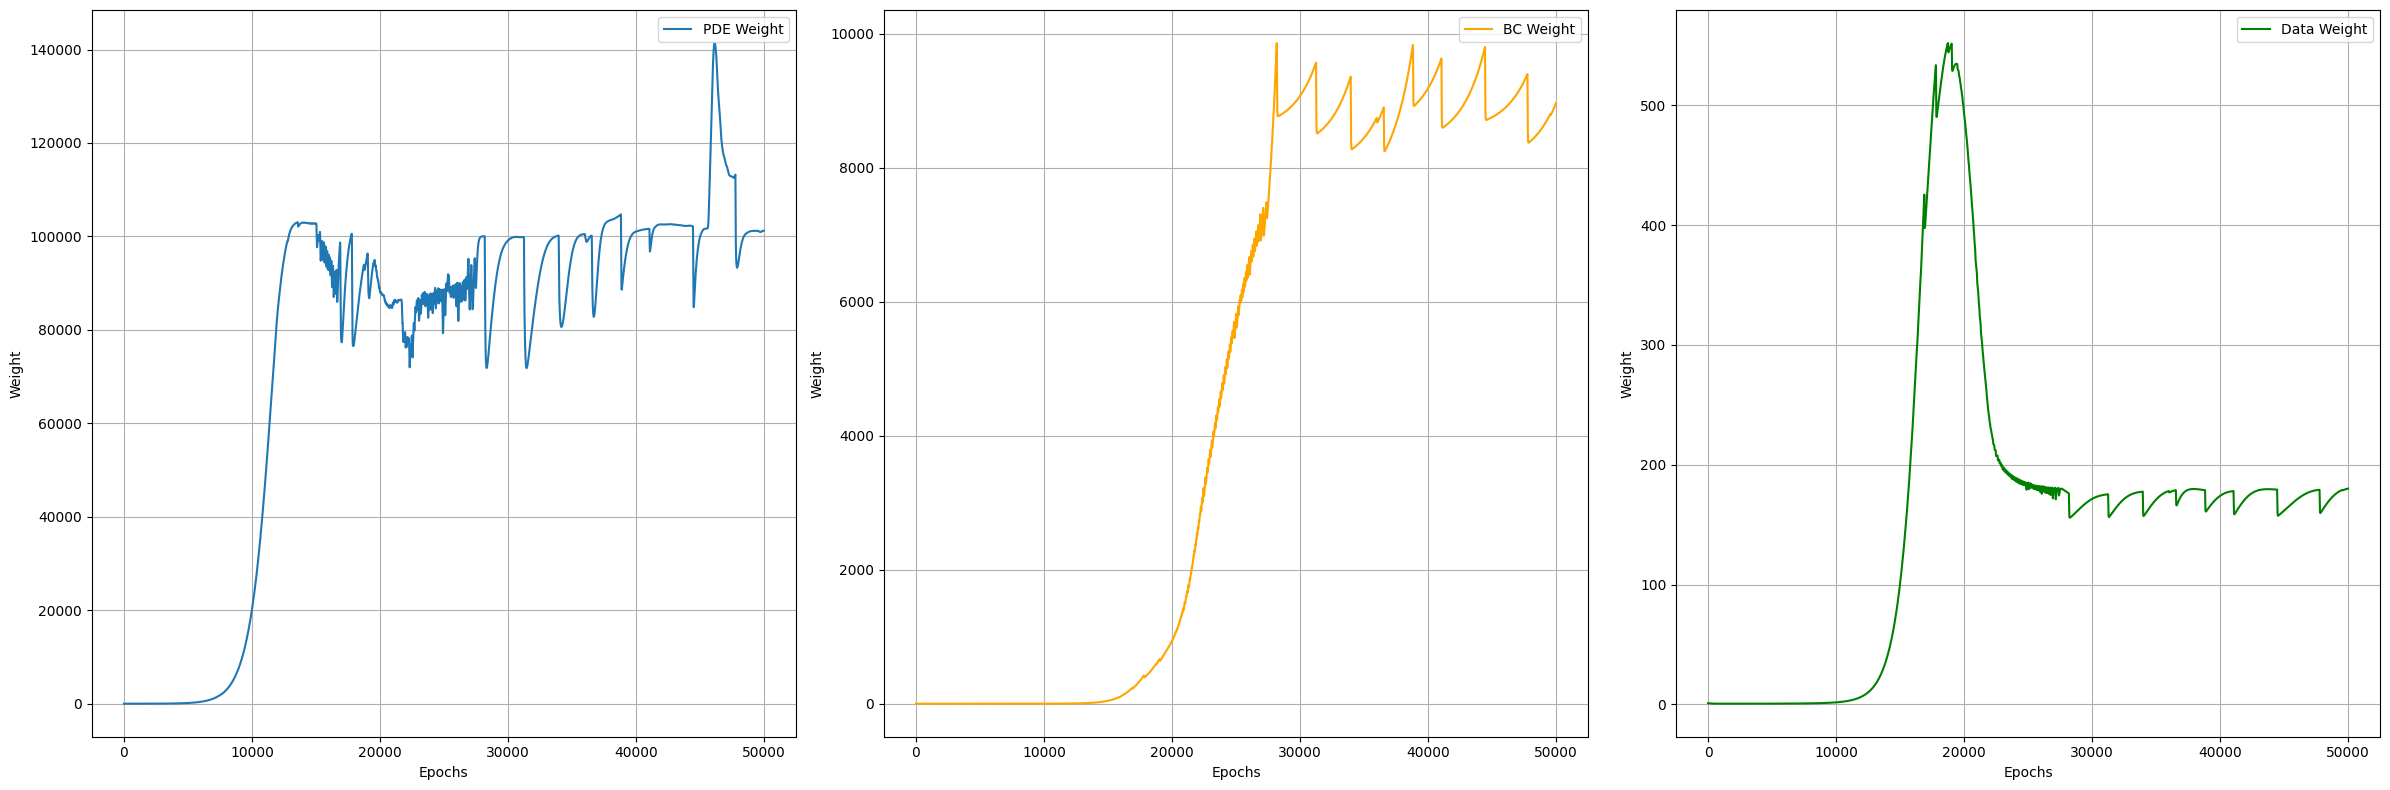

In [17]:
# Create a figure with one row and three columns
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot 'PDE Weight' in the first subplot (axes[0])
axes[0].plot(loss_weights_hist['PDE_Weight'], label='PDE Weight')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Weight')
axes[0].legend()
axes[0].grid(True)

# Plot 'BC Weight' in the second subplot (axes[1])
axes[1].plot(loss_weights_hist['BC_Weight'], label='BC Weight', color='orange')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Weight')
axes[1].legend()
axes[1].grid(True)

# Plot 'Data Weight' in the third subplot (axes[2])
axes[2].plot(loss_weights_hist['Data_Weight'], label='Data Weight', color='green')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Weight')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()  # You can replace with save if needed

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


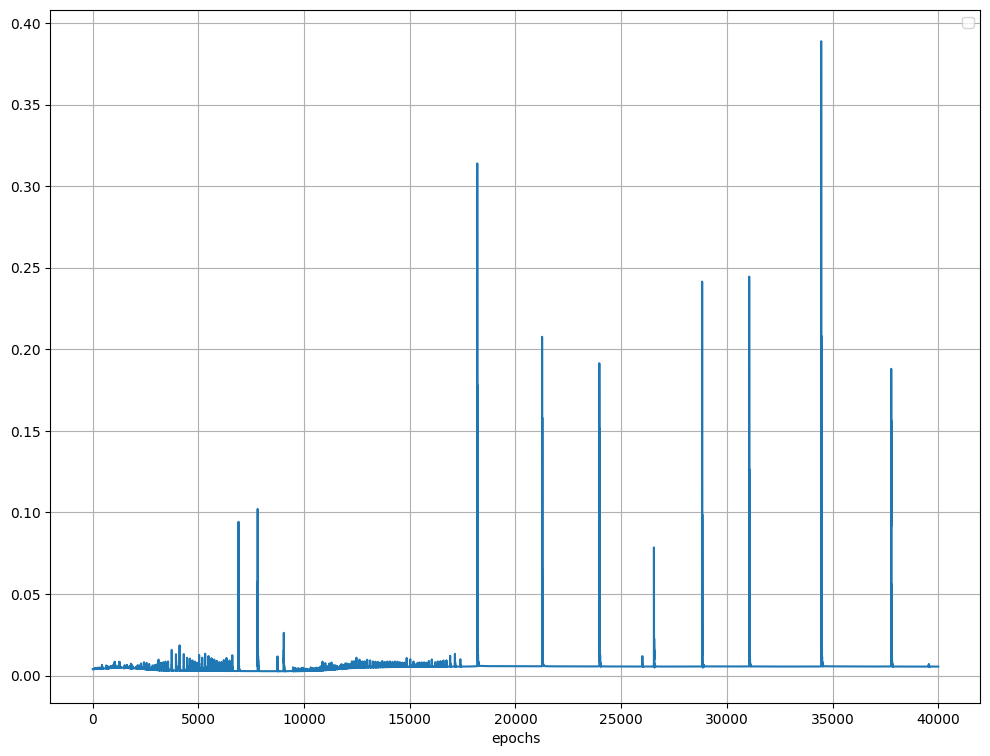

In [15]:
fig = plt.figure(figsize=(12,9))
plt.plot(loss_hist[10000:])
plt.xlabel('epochs')
plt.legend()
plt.grid(True)
plt.show()  # You can replace with save if needed

In [16]:
for i in range(50000):
    if i % 500 == 0:
        print(loss_hist[i])

1110.647705078125
713.512939453125
19.23183250427246
11.594651222229004
1.4876115322113037
0.0038816730957478285
0.0030599692836403847
0.002959632780402899
0.0028882580809295177
0.0028754486702382565
0.0028355298563838005
0.0028626914136111736
0.0028517134487628937
0.0028257952071726322
0.0028885435312986374
0.002962997183203697
0.002880288287997246
0.0031538514886051416
0.0031723782885819674
0.003463389817625284
0.0039276923052966595
0.004366474226117134
0.004712502472102642
0.0050499518401920795
0.004627379588782787
0.003973458893597126
0.003424782305955887
0.0031529422849416733
0.0030421828851103783
0.002983144484460354
0.0028913640417158604
0.0033950558863580227
0.0028733485378324986
0.0030427747406065464
0.0028138691559433937
0.0027609432581812143
0.0027278007473796606
0.0027102180756628513
0.0027049994096159935
0.002825896255671978
0.0028378309216350317
0.0030069455970078707
0.005633257329463959
0.004214316140860319
0.004509711638092995
0.00514318747445941
0.0059738606214523315
0